In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
iea_global = pd.read_csv("IEA GEVO 2023 data.csv")

pcts = iea_global[(iea_global['region'] == "USA")
                  & (iea_global['parameter'].str.contains("sales share"))
                  & (iea_global['mode'] == "Cars")]
pcts.head()

,region,category,parameter,mode,powertrain,year,unit,value
8767,USA,Historical,EV sales share,Cars,EV,2010,percent,0.011
8780,USA,Historical,EV sales share,Cars,EV,2011,percent,0.170
8793,USA,Historical,EV sales share,Cars,EV,2012,percent,0.410
8806,USA,Historical,EV sales share,Cars,EV,2013,percent,0.740
8819,USA,Historical,EV sales share,Cars,EV,2014,percent,0.890


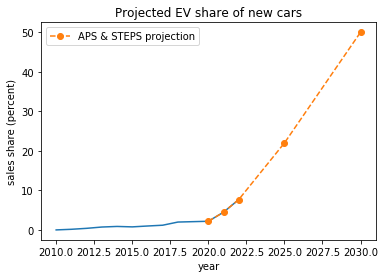

In [3]:
hist = pcts[pcts['category'] == 'Historical']
hist = hist.set_index('year')

proj = pcts[(pcts['category'] == 'Projection-APS')]
proj = proj.set_index('year')

plt.plot(hist['value'])
plt.plot(proj['value'], linestyle='--', marker='o', label="APS & STEPS projection")

plt.xlabel("year")
plt.ylabel("sales share (percent)")
plt.title("Projected EV share of new cars")

plt.legend()
plt.show()

In [5]:
xx = np.arange(2010, 2031)
xx

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030])

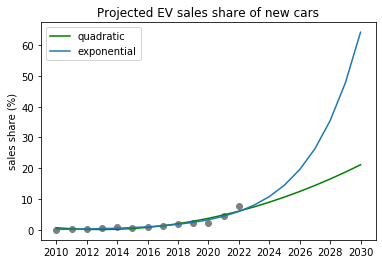

In [14]:
x, y = hist.index, hist['value']
plt.scatter(x, y, c='gray')

xx = np.arange(2010, 2031)
# quadratic
model = np.poly1d(np.polyfit(x, y, 2))
plt.plot(xx, model(xx), c='green', label="quadratic")

# exponential
# for start in np.arange(9):
#     model = np.poly1d(np.polyfit(x[start:], np.log(y[start:]), 1))
#     plt.plot(xx, np.exp(model(xx)), label=f"exponential ({2010+start})")

model = np.poly1d(np.polyfit(x, np.log(y), 1, w=np.arange(len(x))))
plt.plot(xx, np.exp(model(xx)), label=f"exponential")

plt.legend()
plt.title("Projected EV sales share of new cars")
plt.xticks(xx[::2])
plt.ylabel("sales share (%)")
plt.show()

## Sigmoid curve

Fits a sigmoid curve according to the equation:

$$\hat y = \dfrac {M} {1 + e^{-k(x-x_0)}} + b$$

This seems like it might be a better model for our problem than quadratic or exponential, for a few reasons.

1. The long-term behavior is more realistic, since we can't get higher than 100% of market share - so there is a hard cap (and it'll likely take a long time before we reach *exactly* 100%, unless we have some laws that explicitly require it)
1. Growth has been very slow in earlier years but will speed up near the "middle" (now or in the next few years) and slow down when we get closer to 100%.

Note: this dataset is only the proportions of newly sold **cars** that are electric, but our forecasting question considers all vehicles. so we'll need to adjust it somehow (probably downwards) to account for vans and trucks.

In [5]:
def sigmoid(x, k, x0, M=100, b=0):
    return M / (1 + np.exp(-k*(x-x0))) + b

def rmse(true, pred):
    return np.mean((true - pred) ** 2)

# fitting sigmoid curve (naive)
best = None
best_err = None
for x0 in np.arange(2027, 2030):
    for k in np.arange(0.3, 0.7, 0.1):
        for M in np.arange(80, 100, 1):
            pred = sigmoid(x, k, x0, M=M)
            err = rmse(y, pred)
            if best_err is None or err < best_err:
                best = round(k,2), x0, M
                best_err = err

print(best)
print(best_err)

(0.4, 2028, 85)
0.22875084817111352


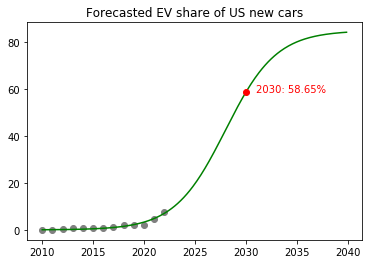

In [6]:
x, y = hist.index, hist['value']
plt.scatter(x, y, c='gray')

# best = (0.3, 2028)

xx = np.arange(2010, 2040, 0.1)
plt.plot(xx, sigmoid(xx, *best), c='green', label="quadratic")

plt.plot(2030, sigmoid(2030, *best), marker='o', c='red')
plt.text(2031, sigmoid(2030, *best), s=f"2030: {round(sigmoid(2030, *best), 2)}%", c='red')

plt.title("Forecasted EV share of US new cars")
plt.ylabel("sales share (%)")
plt.show()

In [7]:
counts = iea_global[(iea_global['region'] == "USA") 
                    & (iea_global['parameter'] == "EV sales")
                    & (iea_global['powertrain'] == "BEV")
                    & (iea_global['mode'] == "Cars")]
counts.head()

,region,category,parameter,mode,powertrain,year,unit,value
8769,USA,Historical,EV sales,Cars,BEV,2010,Vehicles,1200.0
8778,USA,Historical,EV sales,Cars,BEV,2011,Vehicles,9800.0
8795,USA,Historical,EV sales,Cars,BEV,2012,Vehicles,15000.0
8804,USA,Historical,EV sales,Cars,BEV,2013,Vehicles,48000.0
8821,USA,Historical,EV sales,Cars,BEV,2014,Vehicles,63000.0


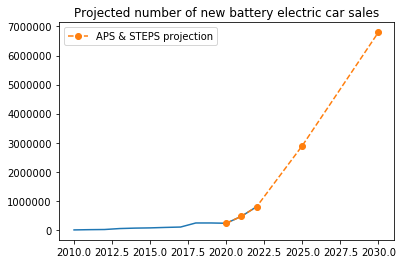

In [8]:
hist_ct = counts[counts['category'] == 'Historical']
hist_ct = hist_ct.set_index('year')

proj = counts[(counts['category'] == 'Projection-APS')]
proj = proj.set_index('year')

plt.plot(hist_ct['value'])
plt.plot(proj['value'], linestyle='--', marker='o', label="APS & STEPS projection")

plt.legend()
plt.title("Projected number of new battery electric car sales")
plt.show()